In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import OrderedDict
from sklearn.utils import shuffle
import matplotlib.cm as cm
sns.set()

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, QuantileTransformer
# Algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples

from tools import *

DATA_DIR = Path('../../data')
PROC_DIR = Path(DATA_DIR / 'processed')
    

flow_columns = ['R [Rsun]', 'B [G]', 'alpha [deg]']
MAX_CLUSTERS = 8

# Load data

In [2]:
filenames = [f for f in PROC_DIR.iterdir()]

flows_dict = OrderedDict()
for f in filenames:
    flows_dict[f.stem] = pd.read_csv(f, usecols=['R [Rsun]', 'B [G]', 'alpha [deg]']) 

## Scale Inputs

In [3]:

# # concat flows
# scaled_flows = list(flows_dict.values())
# scaled_flows = pd.concat(scaled_flows, axis=0)

# scaler = MinMaxScaler((-1,1))
# scaler.fit(scaled_flows)
# scaled_flows = scaler.transform(scaled_flows)

# scaled_flows = pd.DataFrame(scaled_flows, columns=flow_columns)
# print(scaled_flows.shape)
# print(scaled_flows.head())

Only works with the quantile scaler

In [4]:
# concat flows
filenames, scaled_flows = shuffle(filenames, list(flows_dict.values()), random_state=0)
scaled_flows = pd.concat(scaled_flows, axis=0)

scaler = QuantileTransformer()
scaler.fit(scaled_flows)
scaled_flows = scaler.transform(scaled_flows)

scaled_flows = pd.DataFrame(scaled_flows, columns=flow_columns)
print(scaled_flows.shape)
print(scaled_flows.head())

(7533440, 3)
   R [Rsun]     B [G]  alpha [deg]
0  0.000000  0.867210     0.271304
1  0.003944  0.867086     0.271512
2  0.005005  0.866962     0.271724
3  0.006006  0.866844     0.271939
4  0.007007  0.866748     0.272158


# All Columns

In [5]:
# separate into file series
scaled_all = [scaled_flows.iloc[i*640:i*640+640, :] for i in range(len(scaled_flows) // 640)]
scaled_all = [flow.values for flow in scaled_all]
scaled_all = np.array([flow.ravel() for flow in np.array(scaled_all)])
scaled_all.shape

(11771, 1920)

In [6]:
scaled_all[0][:20]

array([0.        , 0.86721046, 0.27130437, 0.0039441 , 0.86708634,
       0.27151226, 0.00500501, 0.86696201, 0.27172377, 0.00600602,
       0.86684415, 0.27193892, 0.00700704, 0.86674773, 0.27215777,
       0.00993784, 0.86665114, 0.27240366, 0.01201202, 0.86655438])

## PCA

In [7]:
pca_640 = PCA(n_components=640)
pca_640.fit(scaled_all)
transf_pca_640 = pca_640.transform(scaled_all)

print("Variance by explained by all components: {:.2f}".format(sum(pca_640.explained_variance_ratio_)*100))

Variance by explained by all components: 100.00


[Text(0.5, 0, 'Number of Components'),
 Text(0, 0.5, 'Cumulative Explained Variance (%)'),
 (0.0, 6.0)]

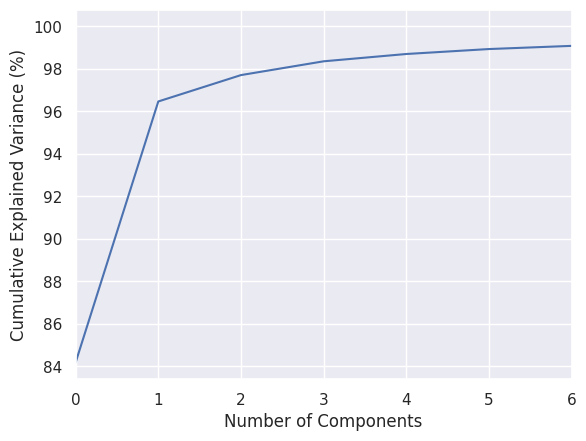

In [8]:
lp = sns.lineplot(np.cumsum(pca_640.explained_variance_ratio_*100))
lp.set(xlabel='Number of Components', ylabel='Cumulative Explained Variance (%)', xlim=(0, 6))

> **Dimensionality**: Most of the data (about 98%) is explained by only 2 components

In [9]:
pca = PCA(n_components=2)
transformed_all = pca.fit_transform(scaled_all)
transformed_all.shape

(11771, 2)

<Axes: >

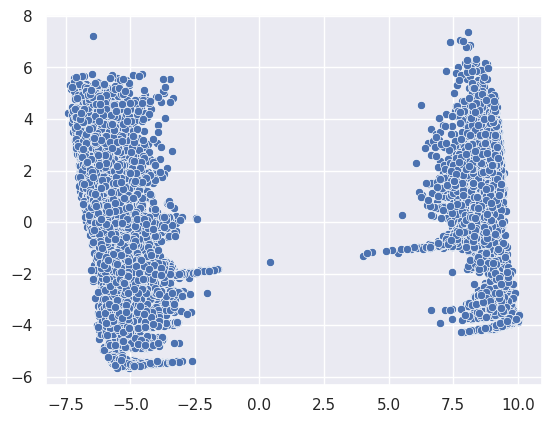

In [10]:
sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1])

## K-Means

[Text(0.5, 0, 'Number of clusters'),
 Text(0, 0.5, 'Distortion'),
 Text(0.5, 1.0, 'Elbow Plot')]

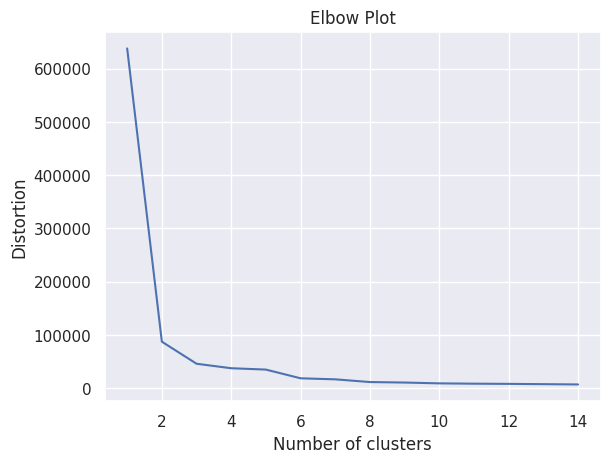

In [11]:
# Elbow Test
distortions = []
K = range(1, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=500, n_init='auto', random_state=1)
    kmeans.fit(transformed_all)
    distortions.append(kmeans.inertia_)
    
ep = sns.lineplot(x=K, y=distortions)
ep.set(xlabel='Number of clusters', ylabel='Distortion', title='Elbow Plot')

For n_clusters = 2 The average silhouette_score is : 0.7769249581017229
For n_clusters = 3 The average silhouette_score is : 0.6466265479721044


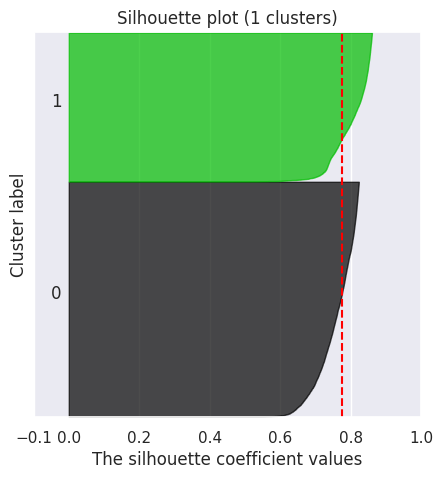

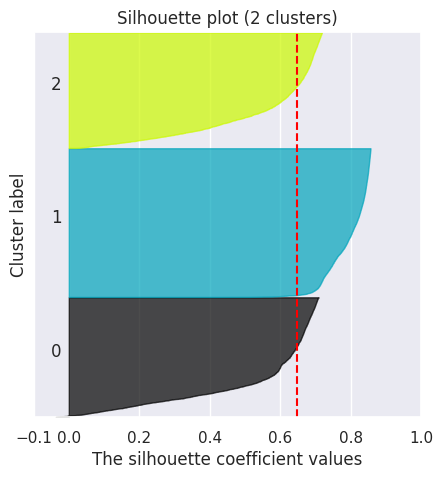

In [12]:
silhouette_plot(transformed_all, 3, KMeans, {'max_iter': 500, 'n_init': 'auto', "random_state" :1})

Silhouette plot 2 e 3

In [13]:
df = clustering_metrics(KMeans, transformed_all, {"random_state" : 1, "n_init" : "auto", "max_iter" : 500})
df

K   S score        DB            CH
0  2  0.776925  0.325785  74261.266024
1  3  0.646627  0.494204  75974.640724
2  4  0.604891  0.567241  62966.835679
3  5  0.552631  0.698411  50851.289867
4  6  0.471305  0.713825  78768.759213
5  7  0.464586  0.747241  73566.750351
6  8  0.437615  0.777022  91850.139425
7  9  0.435456  0.785778  87596.912076

In [14]:
print(df.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{rrrr}
\toprule
K & S score & DB & CH \\
\midrule
2 & 0.777 & 0.326 & 74261.266 \\
3 & 0.647 & 0.494 & 75974.641 \\
4 & 0.605 & 0.567 & 62966.836 \\
5 & 0.553 & 0.698 & 50851.290 \\
6 & 0.471 & 0.714 & 78768.759 \\
7 & 0.465 & 0.747 & 73566.750 \\
8 & 0.438 & 0.777 & 91850.139 \\
9 & 0.435 & 0.786 & 87596.912 \\
\bottomrule
\end{tabular}



In [13]:
kmeans = KMeans(n_clusters=3,max_iter=500, n_init='auto', random_state=1)
pca_kmeans_labels = kmeans.fit_predict(scaled_all)
nclusters = len(set(pca_kmeans_labels))

<Axes: >

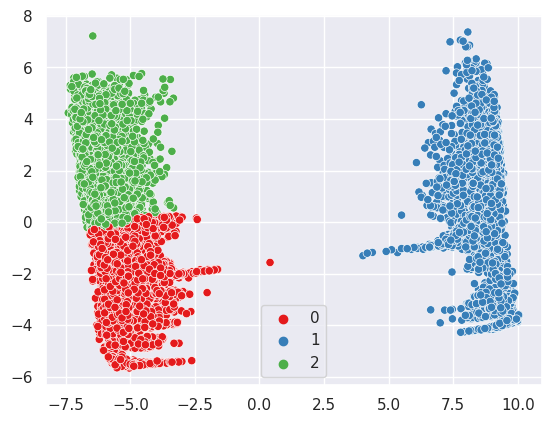

In [14]:
sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=pca_kmeans_labels, palette='Set1')

# Val files

In [17]:
filenames_val = [f for f in Path(DATA_DIR / 'processed_val').iterdir()]

flows_dict_val = OrderedDict()
for f in filenames_val:
    flows_dict_val[f.stem] = pd.read_csv(f, usecols=['R [Rsun]', 'B [G]', 'alpha [deg]']) 
    
# concat flows
filenames_val, scaled_flows_val = shuffle(filenames_val, list(flows_dict_val.values()), random_state=0)
scaled_flows_val = pd.concat(scaled_flows_val, axis=0)

scaled_flows_val = scaler.transform(scaled_flows_val)

scaled_flows_val = pd.DataFrame(scaled_flows_val, columns=flow_columns)
print(scaled_flows_val.shape)
print(scaled_flows_val.head())

# separate into file series
scaled_all_val = [scaled_flows_val.iloc[i*640:i*640+640, :] for i in range(len(scaled_flows_val) // 640)]
scaled_all_val = [flow.values for flow in scaled_all_val]
scaled_all_val = np.array([flow.ravel() for flow in np.array(scaled_all_val)])

transformed_all_val = pca.transform(scaled_all_val)

pca_kmeans_labels = kmeans.predict(scaled_all_val)
nclusters = len(set(pca_kmeans_labels))

(754560, 3)
   R [Rsun]     B [G]  alpha [deg]
0  0.000000  0.721831     0.218173
1  0.002002  0.721721     0.218608
2  0.003724  0.721648     0.219059
3  0.005005  0.721575     0.219578
4  0.007007  0.721503     0.220139


<Axes: >

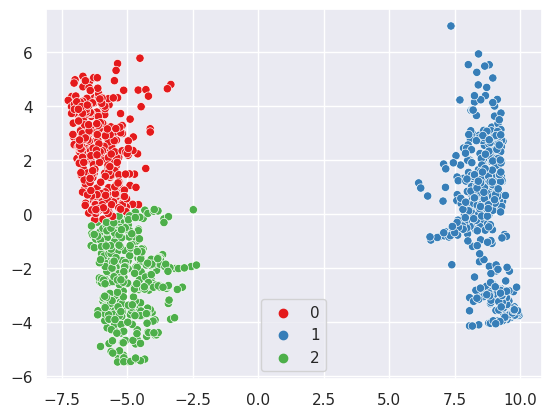

In [18]:
sns.scatterplot(x=transformed_all_val[:, 0], y=transformed_all_val[:, 1], hue=pca_kmeans_labels, palette='Set1')

In [19]:
save_cluster_info(pca_kmeans_labels, list(flows_dict_val.keys()), 1, "quantile_pca_kmeans", Path("."))

### Original Data

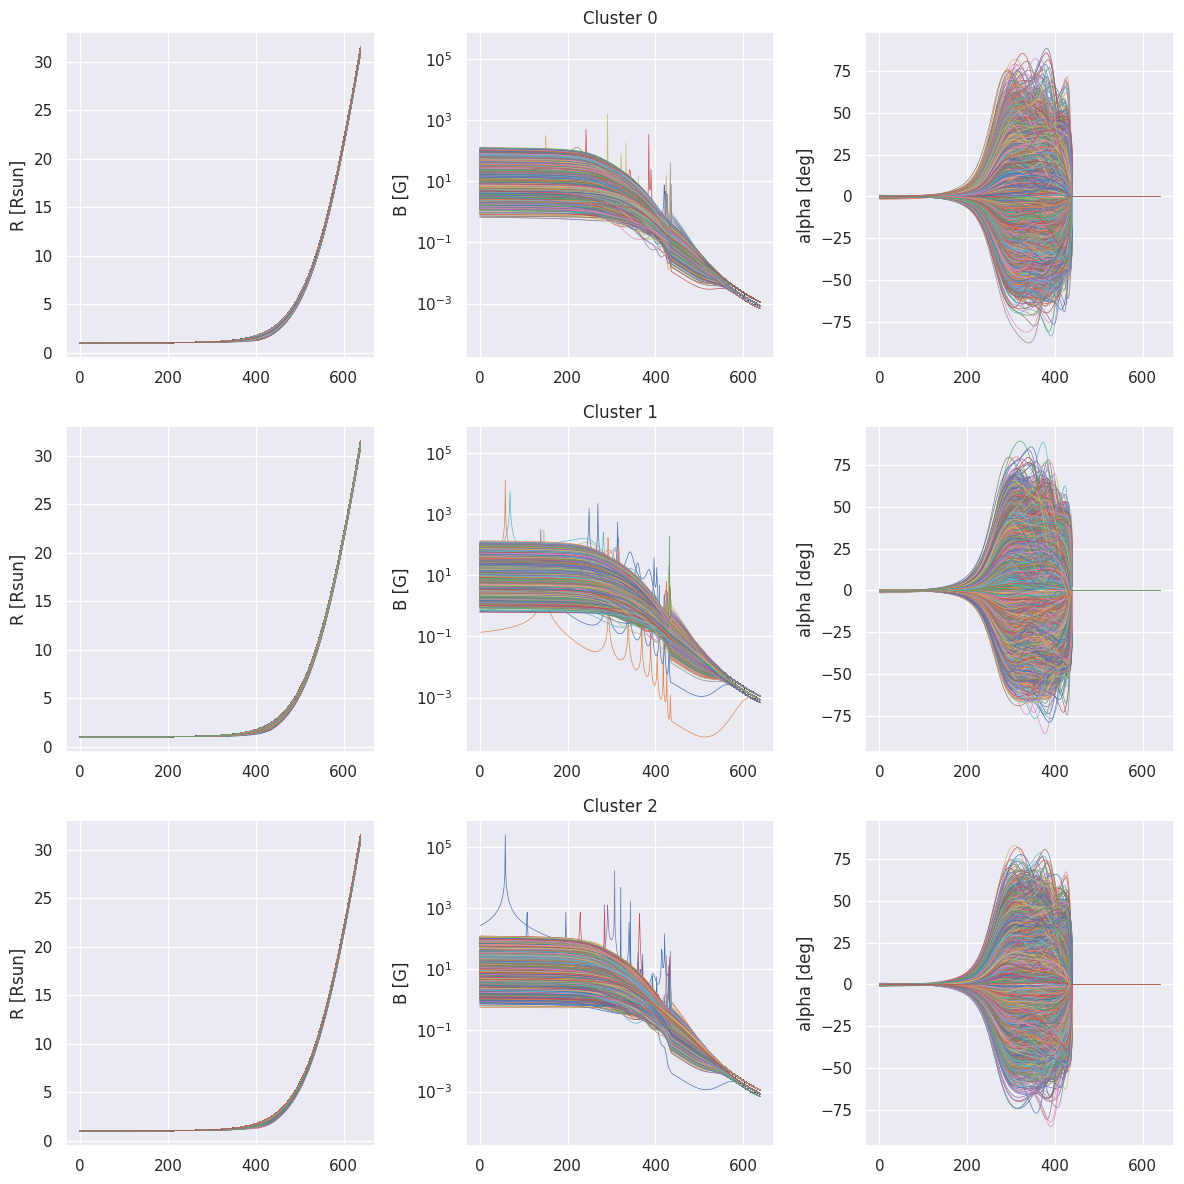

In [15]:
plot_unscaled_clusters(pca_kmeans_labels, nclusters, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

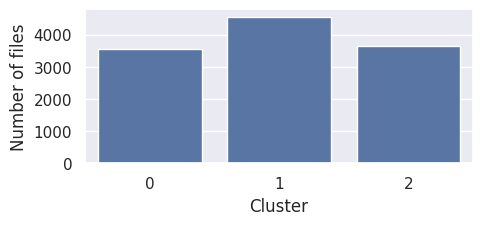

In [8]:
fig, ax = plt.subplots(figsize=(5, 2))
bp = sns.countplot(x=pca_kmeans_labels, ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

### Grid Search

In [ ]:
# %%capture
# subdir = OUT_DIR / 'kmeans'
# if not subdir.exists():
#     subdir.mkdir(parents=True)
    
# for k in range(2, 5):
#     kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto')
#     kmeans_labels = kmeans.fit_predict(transformed_all)
    
#     sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=kmeans_labels, palette='Set1')
#     plt.savefig(subdir / f'scatter_{k}.png', dpi=200)
#     plot_unscaled_clusters(kmeans_labels, k, flows_dict, flow_columns, save_path=subdir / f'unscaled_{k}.png', yscale={'B [G]': 'log'})

## Hierarchical Clustering

For n_clusters = 2 The average silhouette_score is : 0.7777441308600317
For n_clusters = 3 The average silhouette_score is : 0.6325795896608805
For n_clusters = 4 The average silhouette_score is : 0.550504675773292
For n_clusters = 5 The average silhouette_score is : 0.4944017964507739
For n_clusters = 6 The average silhouette_score is : 0.46239640268408944
For n_clusters = 7 The average silhouette_score is : 0.42841959370386223
For n_clusters = 8 The average silhouette_score is : 0.4202631549208201
For n_clusters = 9 The average silhouette_score is : 0.3915234621440803
For n_clusters = 10 The average silhouette_score is : 0.38524478585831595


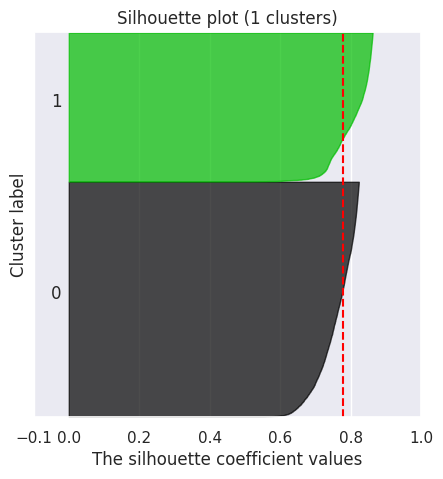

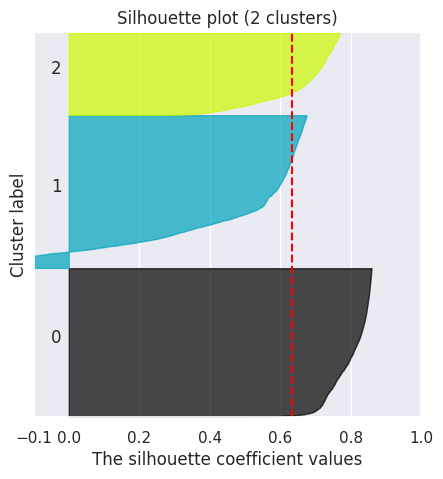

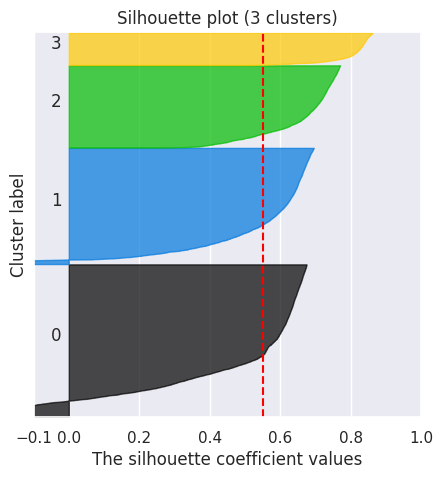

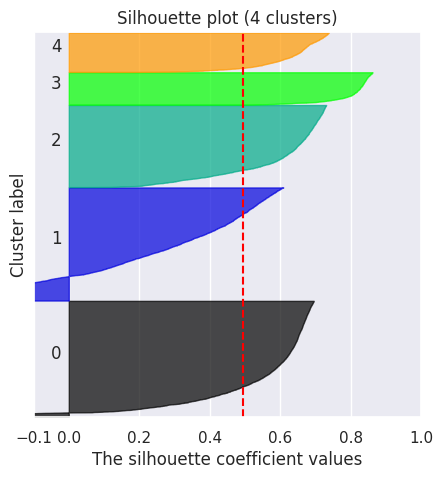

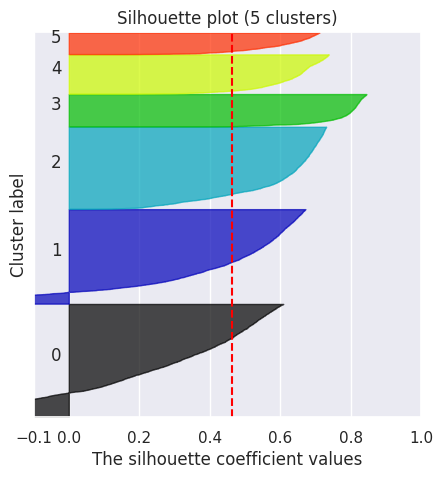

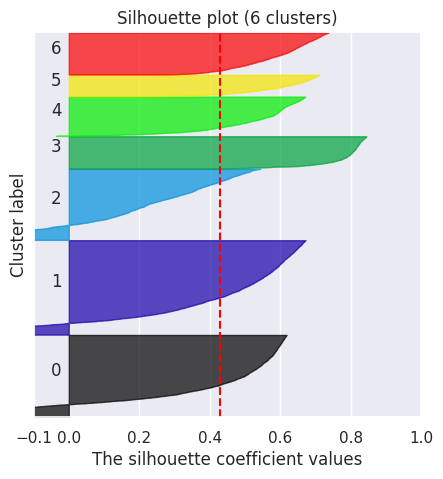

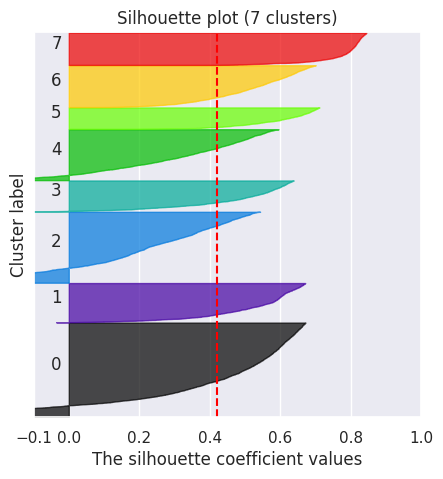

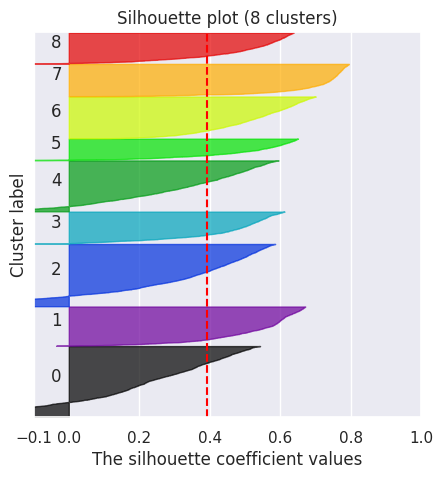

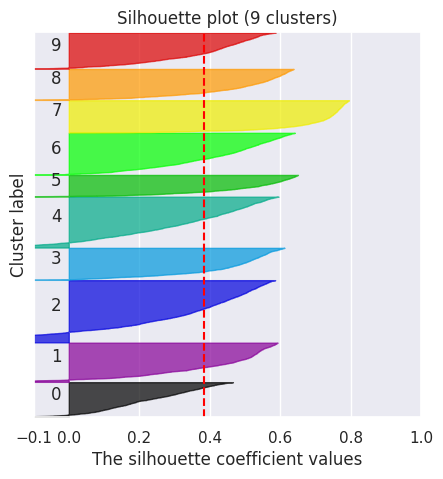

In [ ]:
silhouette_plot(transformed_all, 10, AgglomerativeClustering, {"compute_distances" : True, "compute_full_tree" : True, "linkage" : "ward"})

In [21]:
df = clustering_metrics(AgglomerativeClustering, transformed_all, {"compute_distances" : True, "compute_full_tree" : True, "linkage" : "ward"})
df

K   S score        DB            CH
0  2  0.776925  0.325785  74261.266024
1  3  0.625360  0.502672  70716.323337
2  4  0.543564  0.563821  72768.448203
3  5  0.510316  0.619927  84236.615227
4  6  0.464244  0.704400  86339.809727
5  7  0.426828  0.789377  83135.344417
6  8  0.395849  0.818895  82333.544143
7  9  0.382301  0.857635  82094.920697

In [22]:
print(df.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{rrrr}
\toprule
K & S score & DB & CH \\
\midrule
2 & 0.777 & 0.326 & 74261.266 \\
3 & 0.625 & 0.503 & 70716.323 \\
4 & 0.544 & 0.564 & 72768.448 \\
5 & 0.510 & 0.620 & 84236.615 \\
6 & 0.464 & 0.704 & 86339.810 \\
7 & 0.427 & 0.789 & 83135.344 \\
8 & 0.396 & 0.819 & 82333.544 \\
9 & 0.382 & 0.858 & 82094.921 \\
\bottomrule
\end{tabular}



In [ ]:
agg = AgglomerativeClustering(compute_distances=True, n_clusters=2, compute_full_tree=True, linkage='average')
agg = agg.fit(transformed_all)
nclusters = len(set(agg.labels_))

Text(0.5, 0, 'Number of points in node')

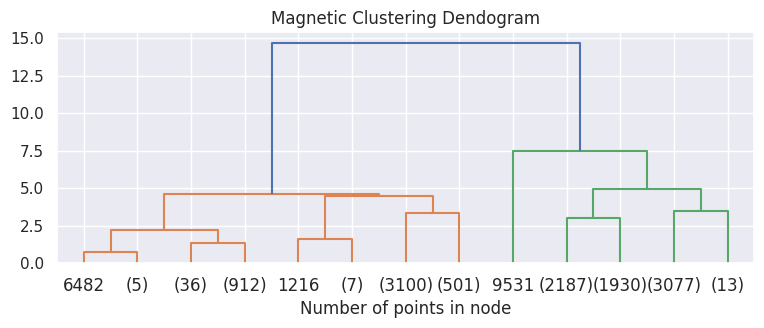

In [ ]:
plt.figure(figsize=(9, 3))
plt.title("Magnetic Clustering Dendogram")
plot_dendrogram(agg, truncate_mode='level', p=3)
plt.xlabel("Number of points in node")

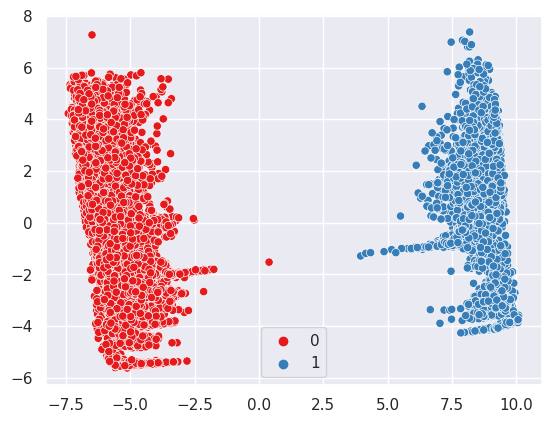

In [ ]:
sp = sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=agg.labels_, palette='Set1')
# sp.legend_.remove()


### Original Data

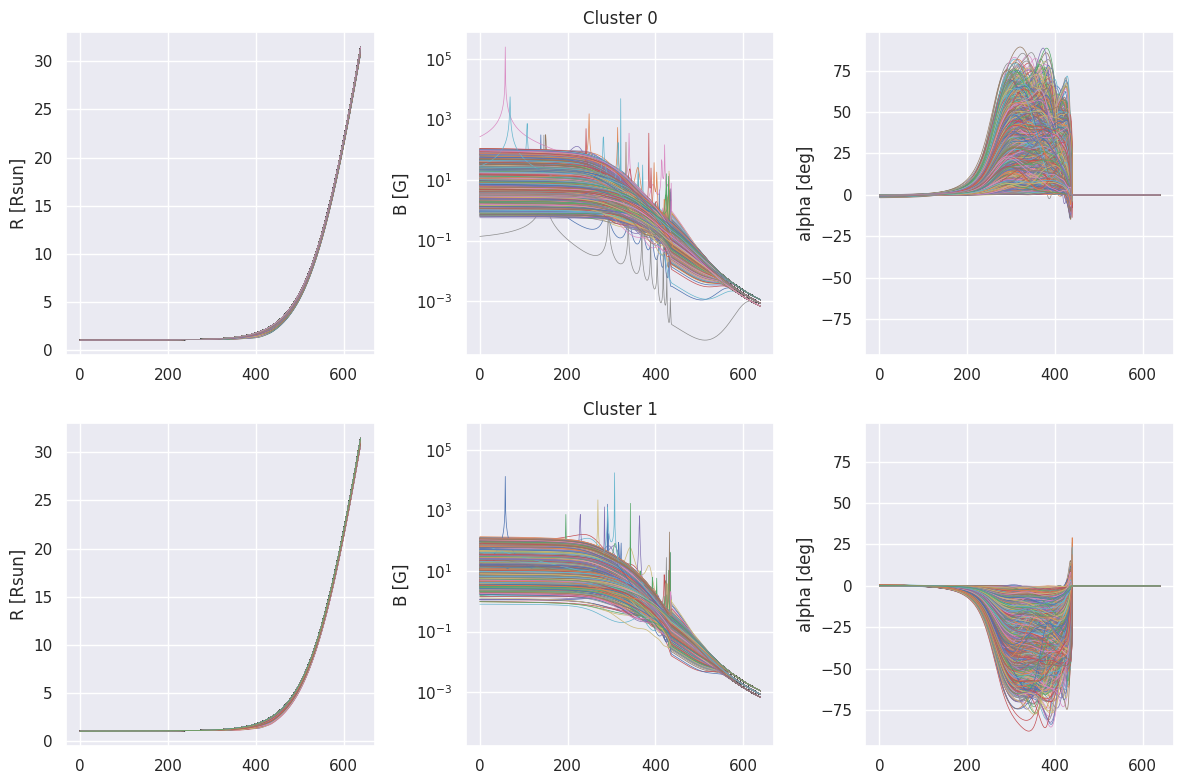

In [ ]:
plot_unscaled_clusters(agg.labels_, nclusters, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

<AxesSubplot: ylabel='count'>

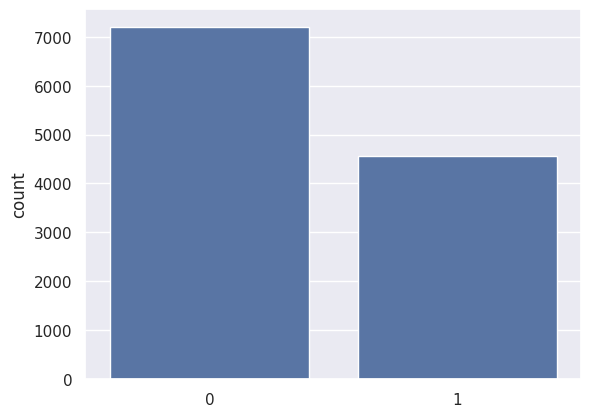

In [ ]:
sns.countplot(x=agg.labels_, color='b')

### Grid Search

In [ ]:
# %%capture
# sub_dir = OUT_DIR / 'hierarchical'
# if not sub_dir.exists():
#     sub_dir.mkdir()
    
# for i in range(2, MAX_CLUSTERS):
#     agg = AgglomerativeClustering(compute_distances=True, n_clusters=i, compute_full_tree=True, linkage='average')
#     agg = agg.fit(transformed_all)
    
#     sp = sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=agg.labels_, palette='Set1') 
#     plt.savefig(sub_dir / f'scatter_{i}.png', dpi=200)
    
#     plot_unscaled_clusters(agg.labels_, i, flows_dict, flow_columns, save_path=sub_dir / f'unscaled_{i}.png', yscale={'B [G]': 'log'}) 
    

## DBSCAN

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=5, n_jobs=2)
dbscan_labels = dbscan.fit_predict(transformed_all)
nclusters = len(set(dbscan_labels))

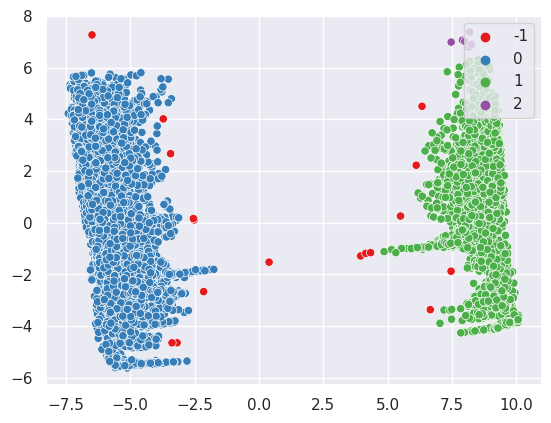

In [ ]:
sp = sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=dbscan_labels, palette='Set1')
plt.legend(loc='upper right')

### Original Data

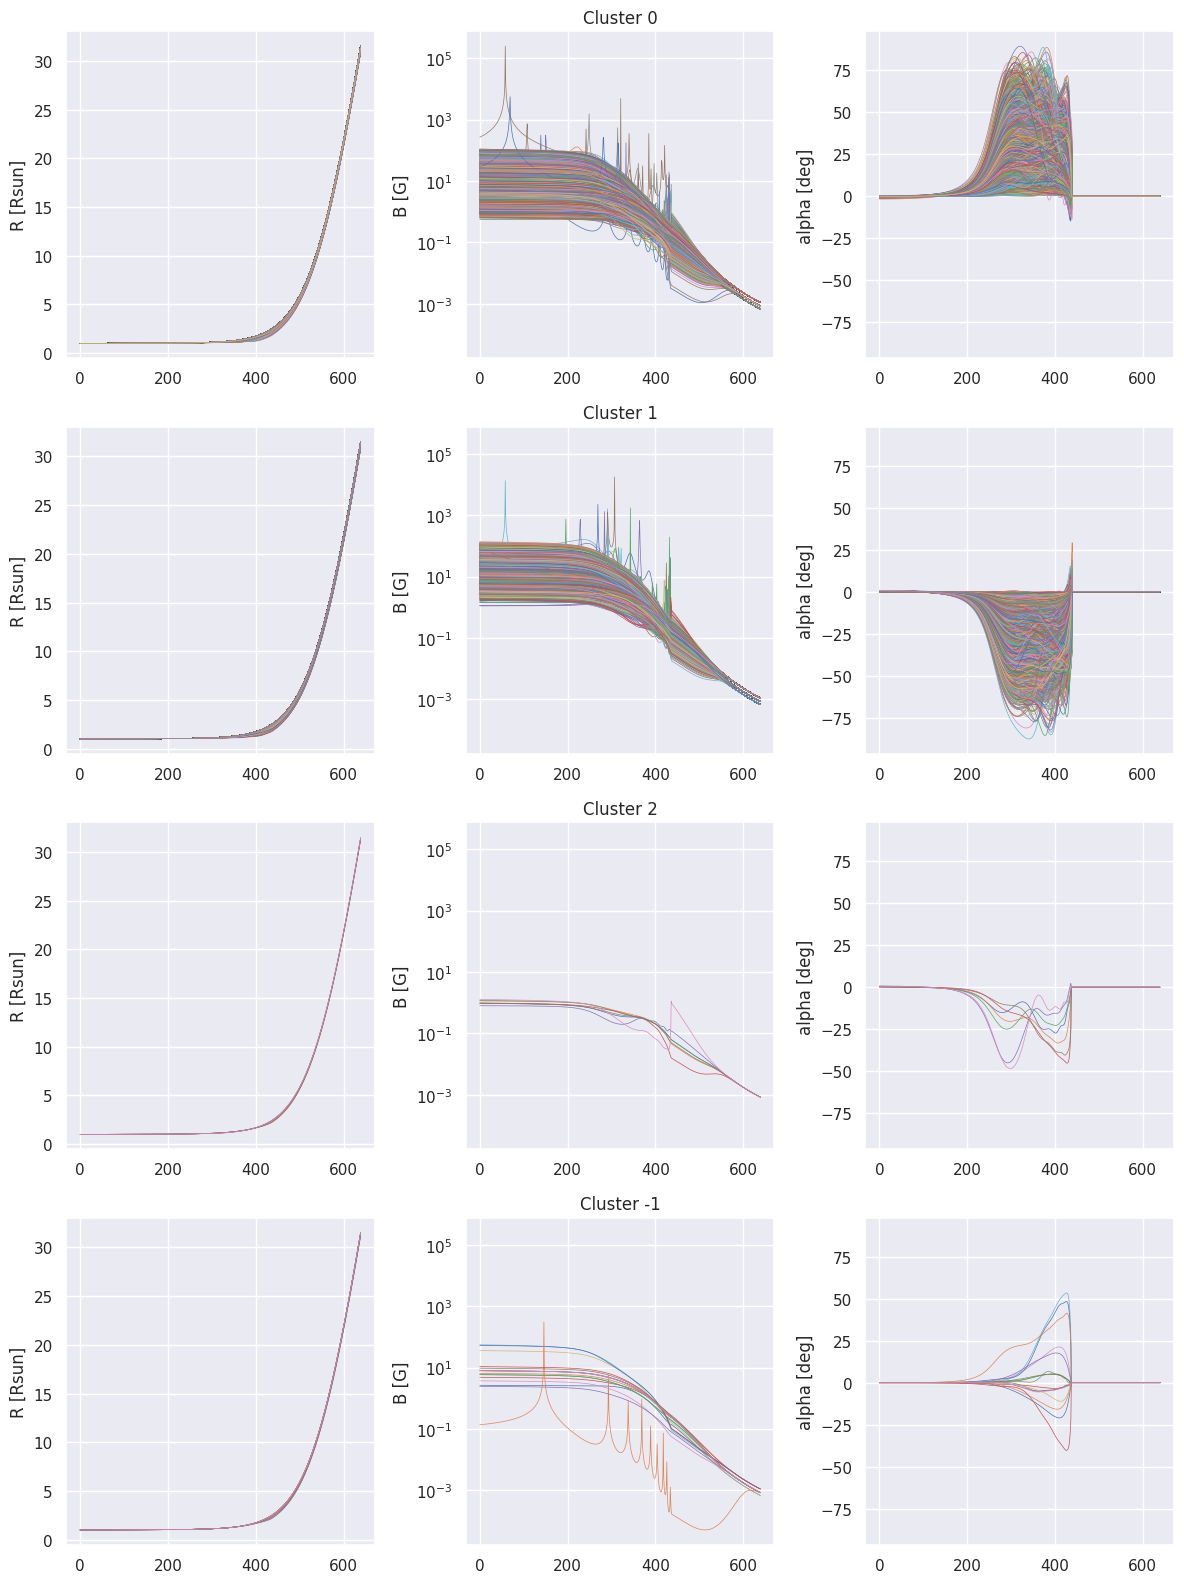

In [ ]:
plot_unscaled_clusters(dbscan_labels, nclusters, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

<AxesSubplot: ylabel='count'>

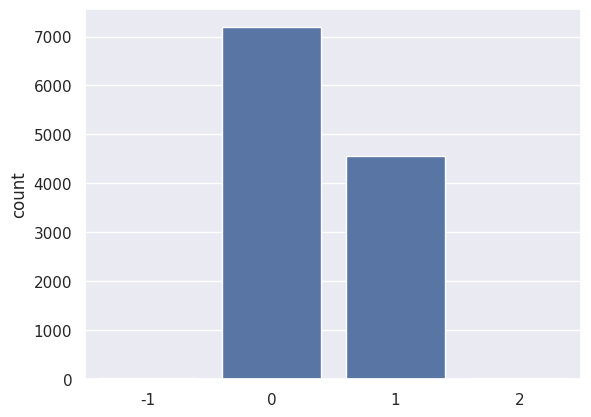

In [ ]:
sns.countplot(x=dbscan_labels, color='b')

### Grid Search

In [ ]:
# %%capture
# sub_dir = OUT_DIR / 'dbscan'
# if not sub_dir.exists():
#     sub_dir.mkdir()


# for k in range(3, 640):
#     for i in np.arange(0.05, 0.9, 0.05):
#         dbscan = DBSCAN(eps=i, min_samples=k, n_jobs=-1)
#         dbscan_labels = dbscan.fit_predict(transformed_all)
        
#         nclusters = len(set(dbscan_labels))
#         if (nclusters > MAX_CLUSTERS or nclusters < 2):
#             continue
        
#         save_i = int(i*100)
#         sp = sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=dbscan_labels, palette='Set1')
#         plt.legend(loc='upper right')
#         plt.savefig(sub_dir / f'scatter_{k}_{save_i}.png', dpi=200)
        
#         plot_unscaled_clusters(dbscan_labels, len(set(dbscan_labels)), flows_dict, flow_columns, 
#                                save_path=sub_dir / f'unscaled_{k}_{save_i}.png', yscale={'B [G]': 'log'})
    

# Magnetic Field + Inclination

In [ ]:
# separate into file series
scaled_mag_inc = [scaled_flows.iloc[i*640:i*640+640, 1:] for i in range(len(scaled_flows) // 640)]
scaled_mag_inc = [flow.values for flow in scaled_mag_inc]
scaled_mag_inc = np.array([flow.ravel() for flow in np.array(scaled_mag_inc)])
scaled_mag_inc.shape

(11771, 1280)

## PCA

In [ ]:
pca_640 = PCA(n_components=640)
pca_640.fit(scaled_mag_inc)
transf_pca_640 = pca_640.transform(scaled_mag_inc)

print("Variance by explained by all components: {:.2f}".format(sum(pca_640.explained_variance_ratio_)*100))

Variance by explained by all components: 100.00


[Text(0.5, 0, 'Number of Components'),
 Text(0, 0.5, 'Cumulative Explained Variance (%)'),
 (0.0, 6.0)]

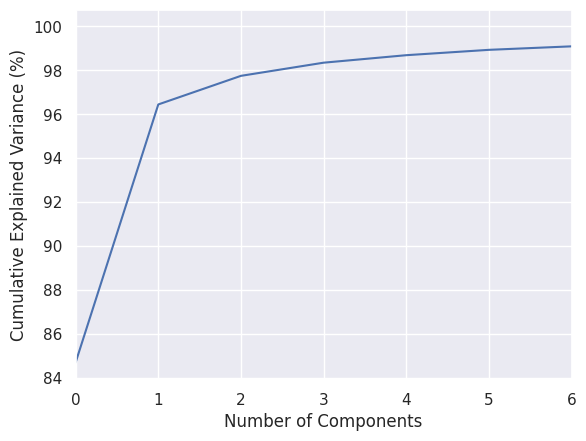

In [ ]:
lp = sns.lineplot(np.cumsum(pca_640.explained_variance_ratio_*100))
lp.set(xlabel='Number of Components', ylabel='Cumulative Explained Variance (%)', xlim=(0, 6))

In [ ]:
pca = PCA(n_components=2)
transformed_mag_inc = pca.fit_transform(scaled_mag_inc)
transformed_mag_inc

array([[-4.86709186, -1.07599434],
       [-4.96854656, -2.67889132],
       [ 8.43887118,  4.67143389],
       ...,
       [-6.33512748,  2.31860732],
       [ 8.87540087,  3.105855  ],
       [ 7.93848004,  1.86800252]])

<AxesSubplot: >

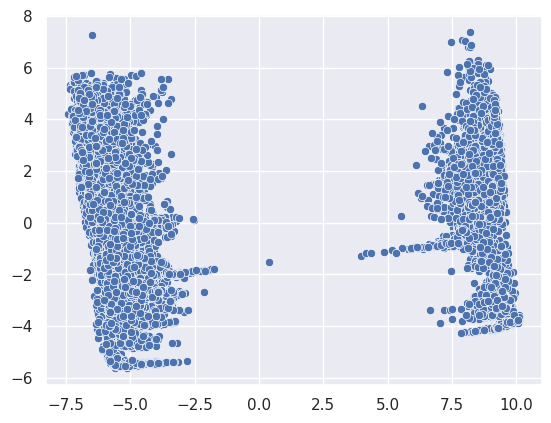

In [ ]:
sns.scatterplot(x=transformed_mag_inc[:, 0], y=transformed_mag_inc[:, 1])

## K-Means

[Text(0.5, 0, 'Number of clusters'),
 Text(0, 0.5, 'Distortion'),
 Text(0.5, 1.0, 'Elbow Plot')]

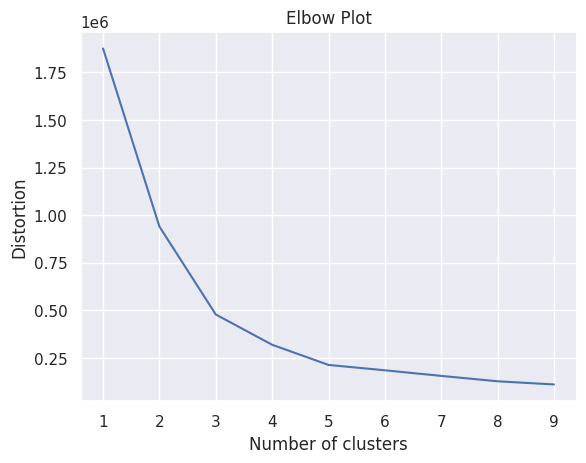

In [ ]:
# Elbow Test
distortions = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto')
    kmeans.fit(scaled_flows)
    distortions.append(kmeans.inertia_)
    
ep = sns.lineplot(x=K, y=distortions)
ep.set(xlabel='Number of clusters', ylabel='Distortion', title='Elbow Plot')
    

In [ ]:
kmeans = KMeans(n_clusters=8,max_iter=5000, n_init='auto')
pca_kmeans_mag_inc_labels = kmeans.fit_predict(transformed_mag_inc)
nclusters = len(set(pca_kmeans_mag_inc_labels))

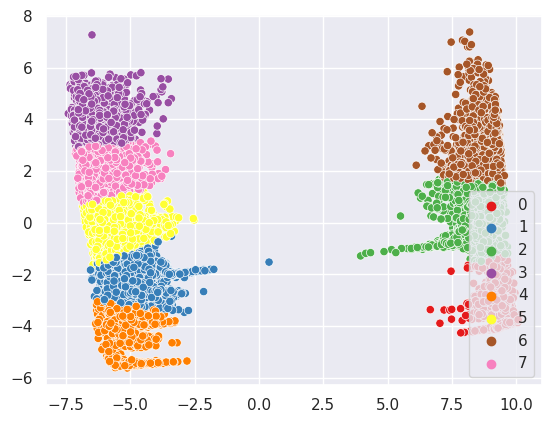

In [ ]:
sp = sns.scatterplot(x=transformed_mag_inc[:, 0], y=transformed_mag_inc[:, 1], hue=pca_kmeans_mag_inc_labels, palette='Set1')
plt.legend(loc='lower right')

### Original Data

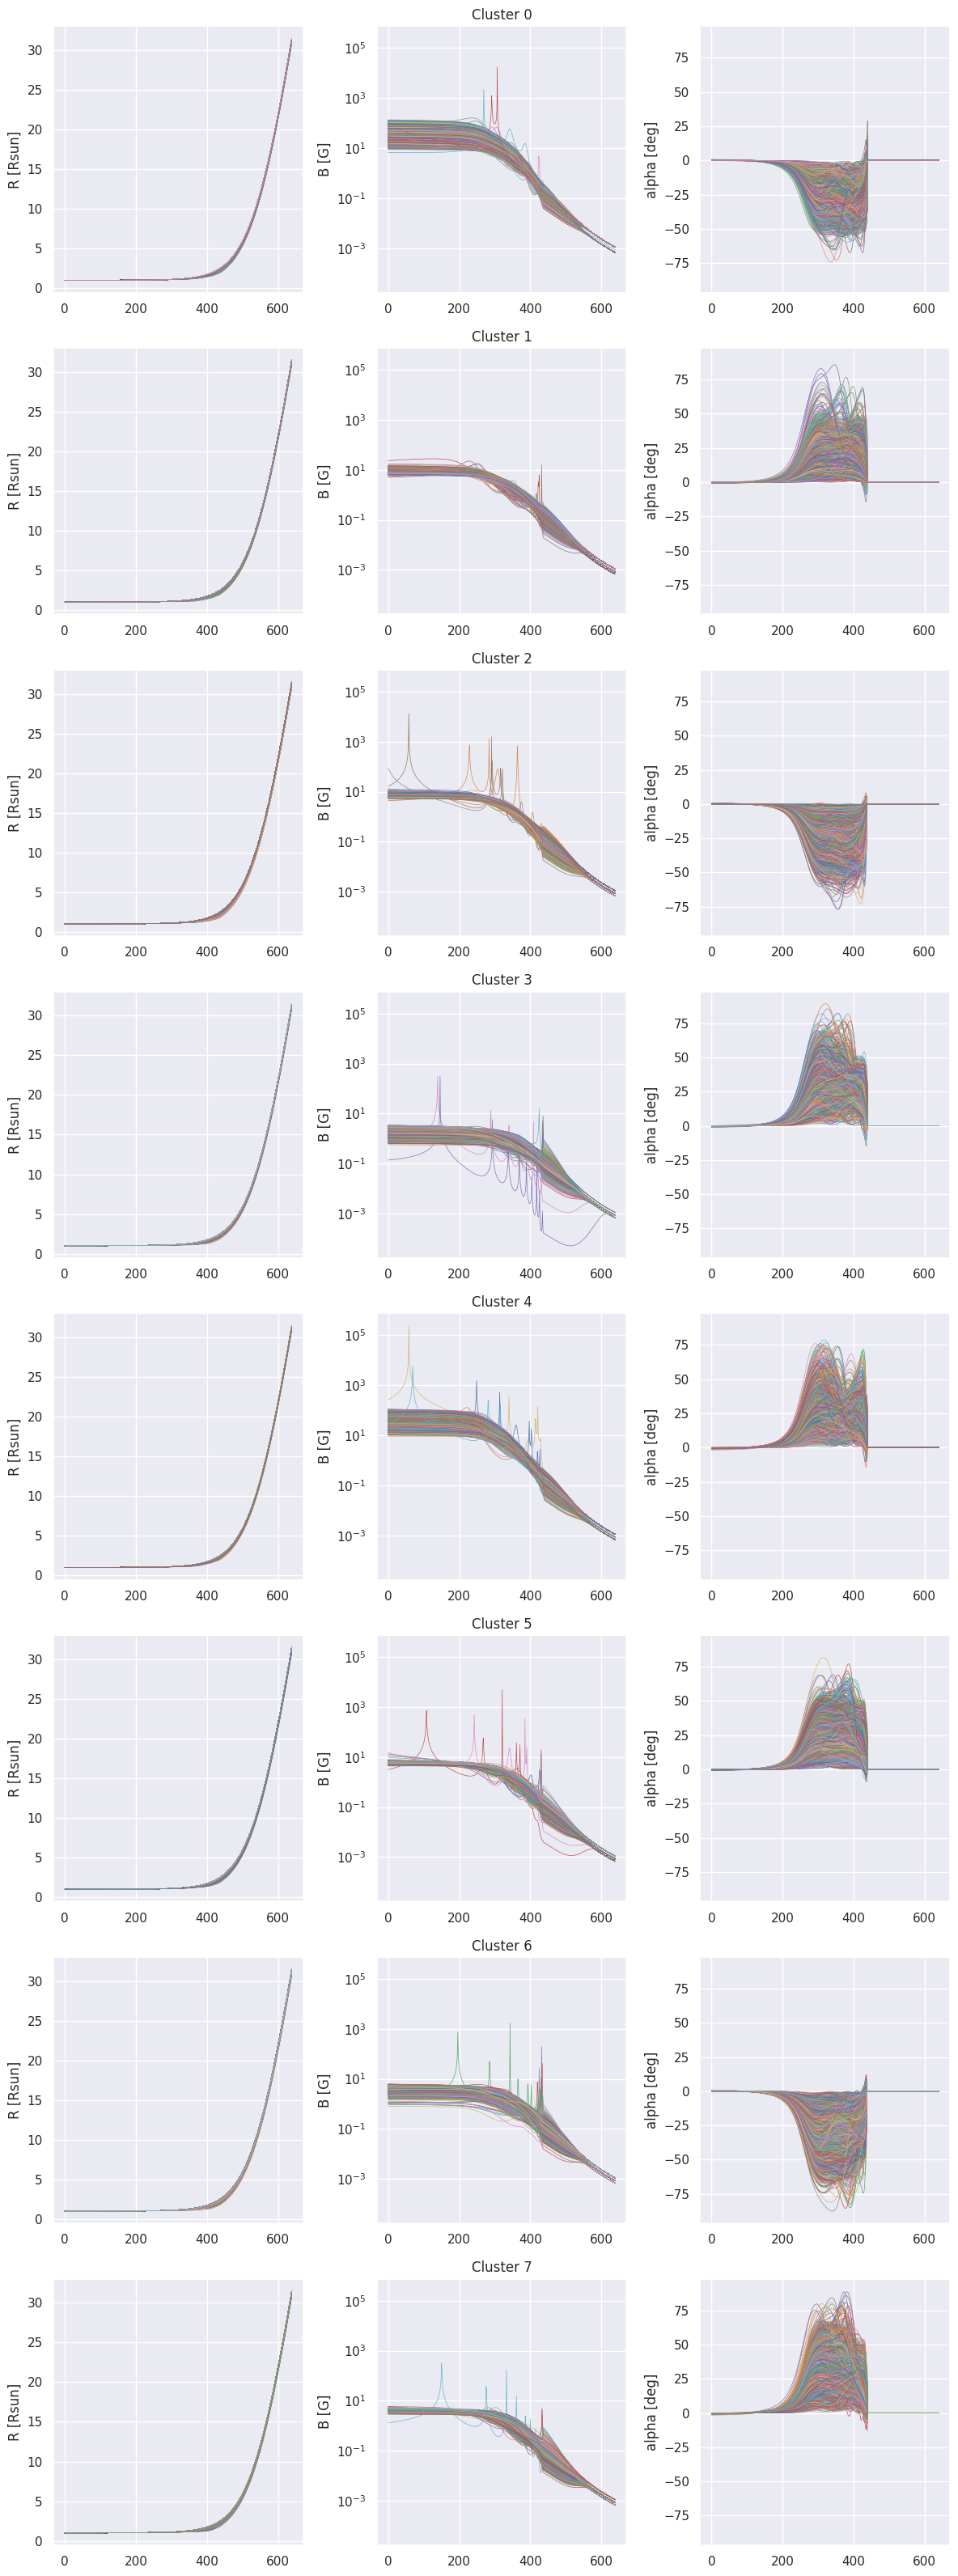

In [ ]:
plot_unscaled_clusters(pca_kmeans_mag_inc_labels, nclusters, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

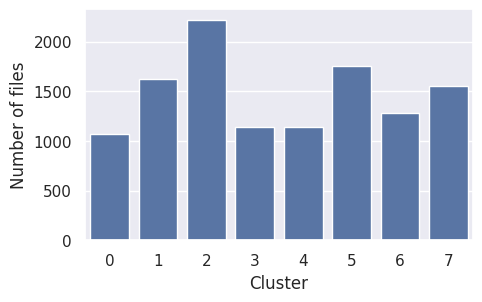

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))
bp = sns.countplot(x=pca_kmeans_mag_inc_labels, ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

## Hierarchical Clustering

In [ ]:
agg = AgglomerativeClustering(compute_distances=True, n_clusters=4, compute_full_tree=True, linkage='average')
agg = agg.fit(transformed_mag_inc)
nclusters = len(set(agg.labels_))

Text(0.5, 0, 'Number of points in node')

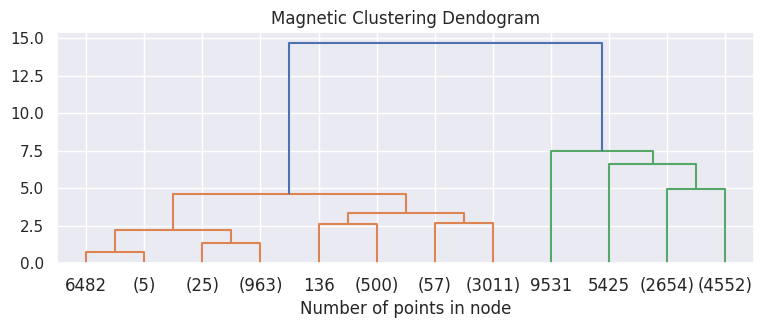

In [ ]:
plt.figure(figsize=(9, 3))
plt.title("Magnetic Clustering Dendogram")
plot_dendrogram(agg, truncate_mode='level', p=3)
plt.xlabel("Number of points in node")

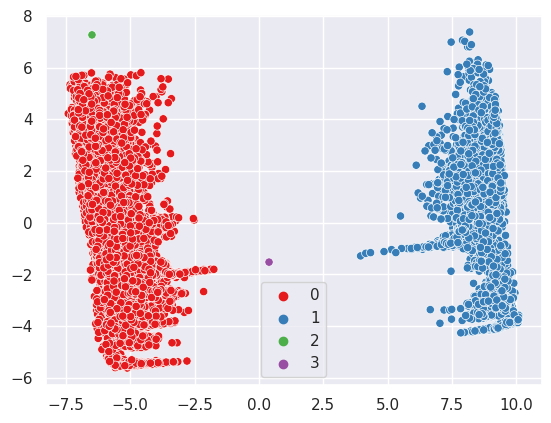

In [ ]:
sp = sns.scatterplot(x=transformed_mag_inc[:, 0], y=transformed_mag_inc[:, 1], hue=agg.labels_, palette='Set1')
# sp.legend_.remove()


### Original Data

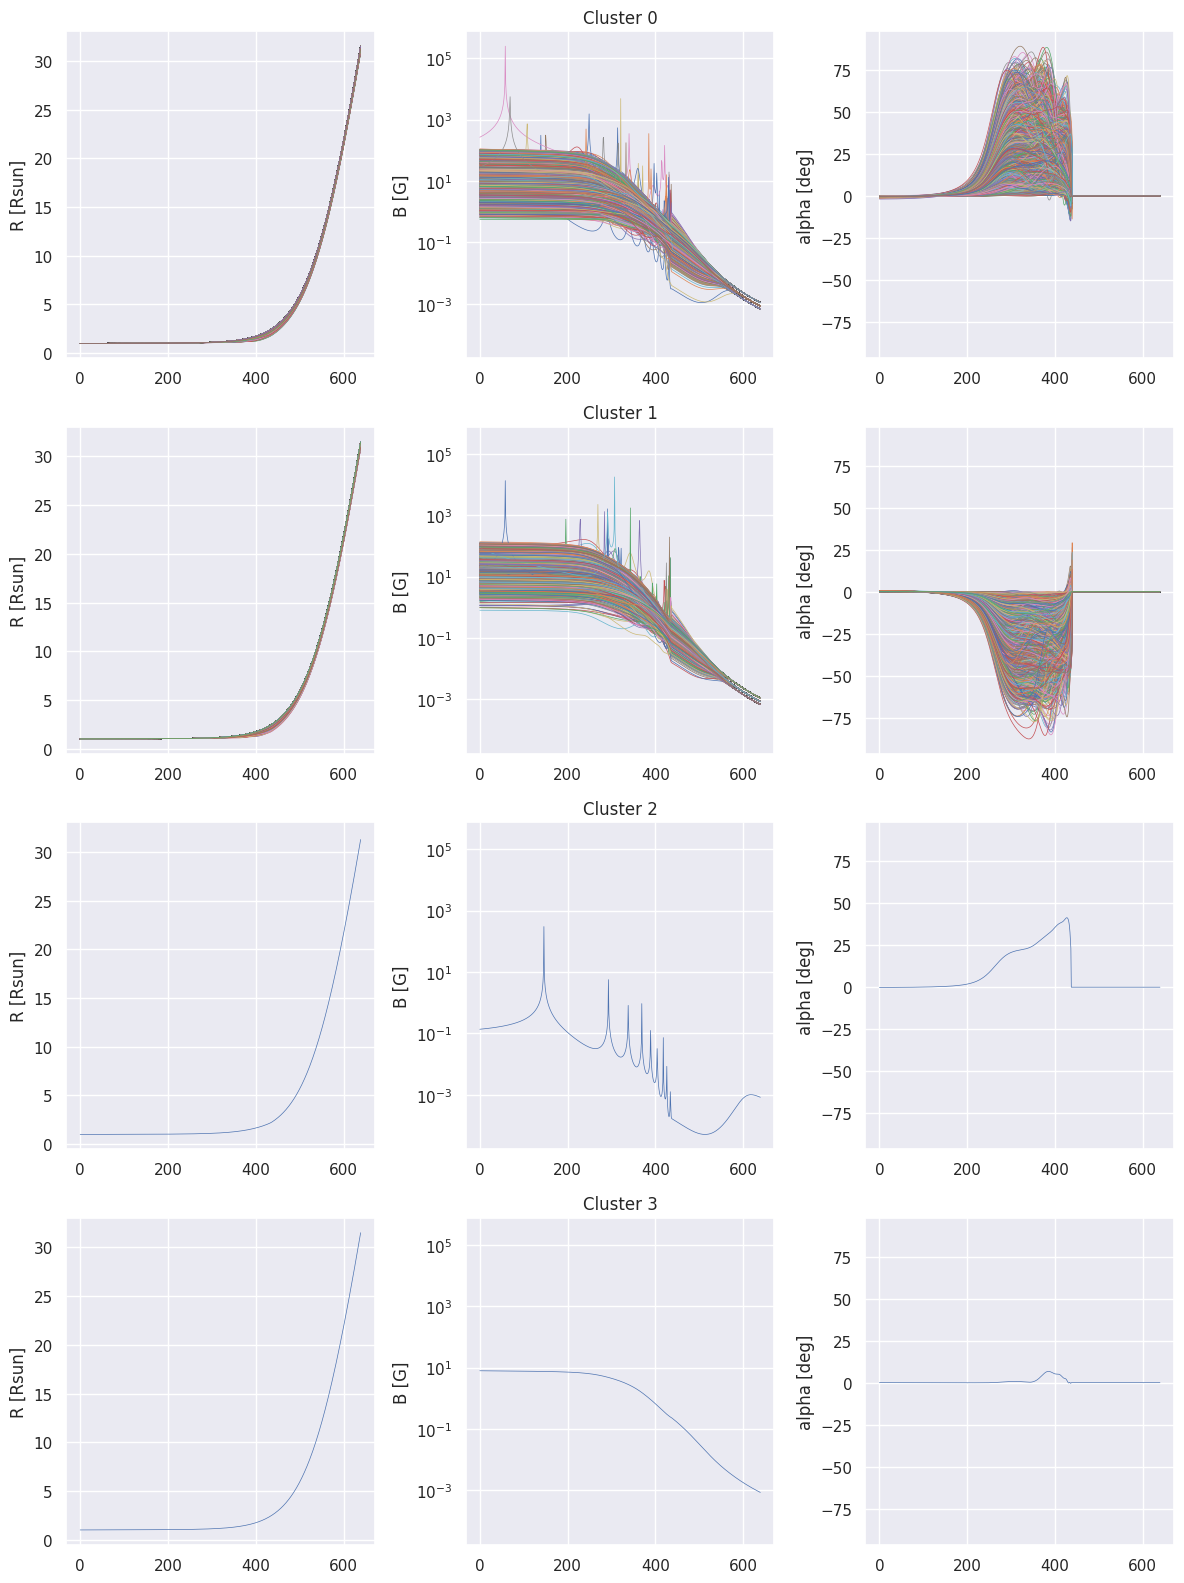

In [ ]:
plot_unscaled_clusters(agg.labels_, nclusters, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

<AxesSubplot: ylabel='count'>

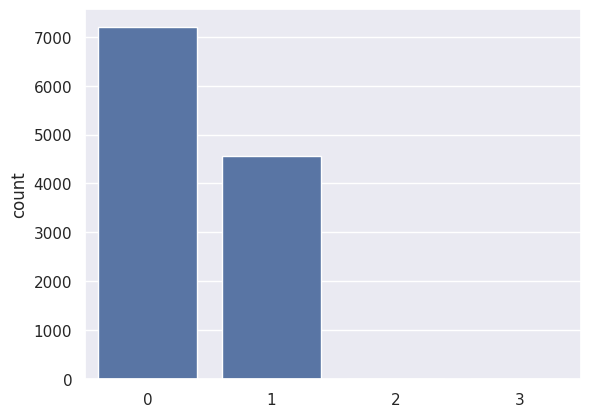

In [ ]:
sns.countplot(x=agg.labels_, color='b')

In [ ]:
# %%capture
# sub_dir = OUT_DIR / 'alpha'
# if not sub_dir.exists():
#     sub_dir.mkdir()
    
# for i in range(2, MAX_CLUSTERS):
#     agg = AgglomerativeClustering(compute_distances=True, n_clusters=i, compute_full_tree=True, linkage='average')
#     agg = agg.fit(transformed_alpha)
    
#     sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=agg.labels_, palette='Set1')
    
        
#     plt.savefig(sub_dir / f'hierarch_scatter_{len(set(agg.labels_))}.png', dpi=200)
    
#     plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns, 
#                            save_path=sub_dir / f'hierarch_{len(set(agg.labels_))}.png', yscale={'B [G]': 'log'}) 
    

## DBSCAN

In [ ]:
dbscan = DBSCAN(eps=0.25, min_samples=10, n_jobs=2)
dbscan_mag_inc_labels = dbscan.fit_predict(transformed_mag_inc)
nclusters = len(set(dbscan_mag_inc_labels))


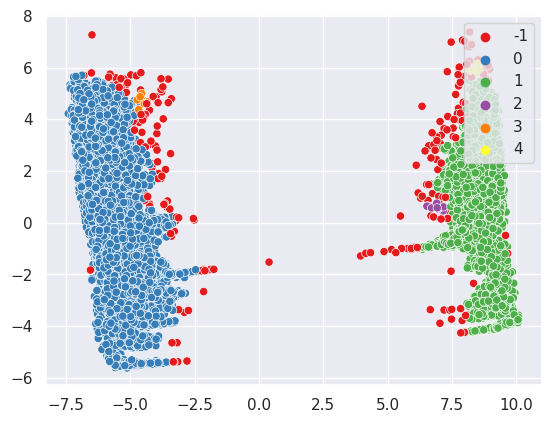

In [ ]:
sp = sns.scatterplot(x=transformed_mag_inc[:, 0], y=transformed_mag_inc[:, 1], hue=dbscan_mag_inc_labels, palette='Set1')
plt.legend(loc='upper right')

### Original Data

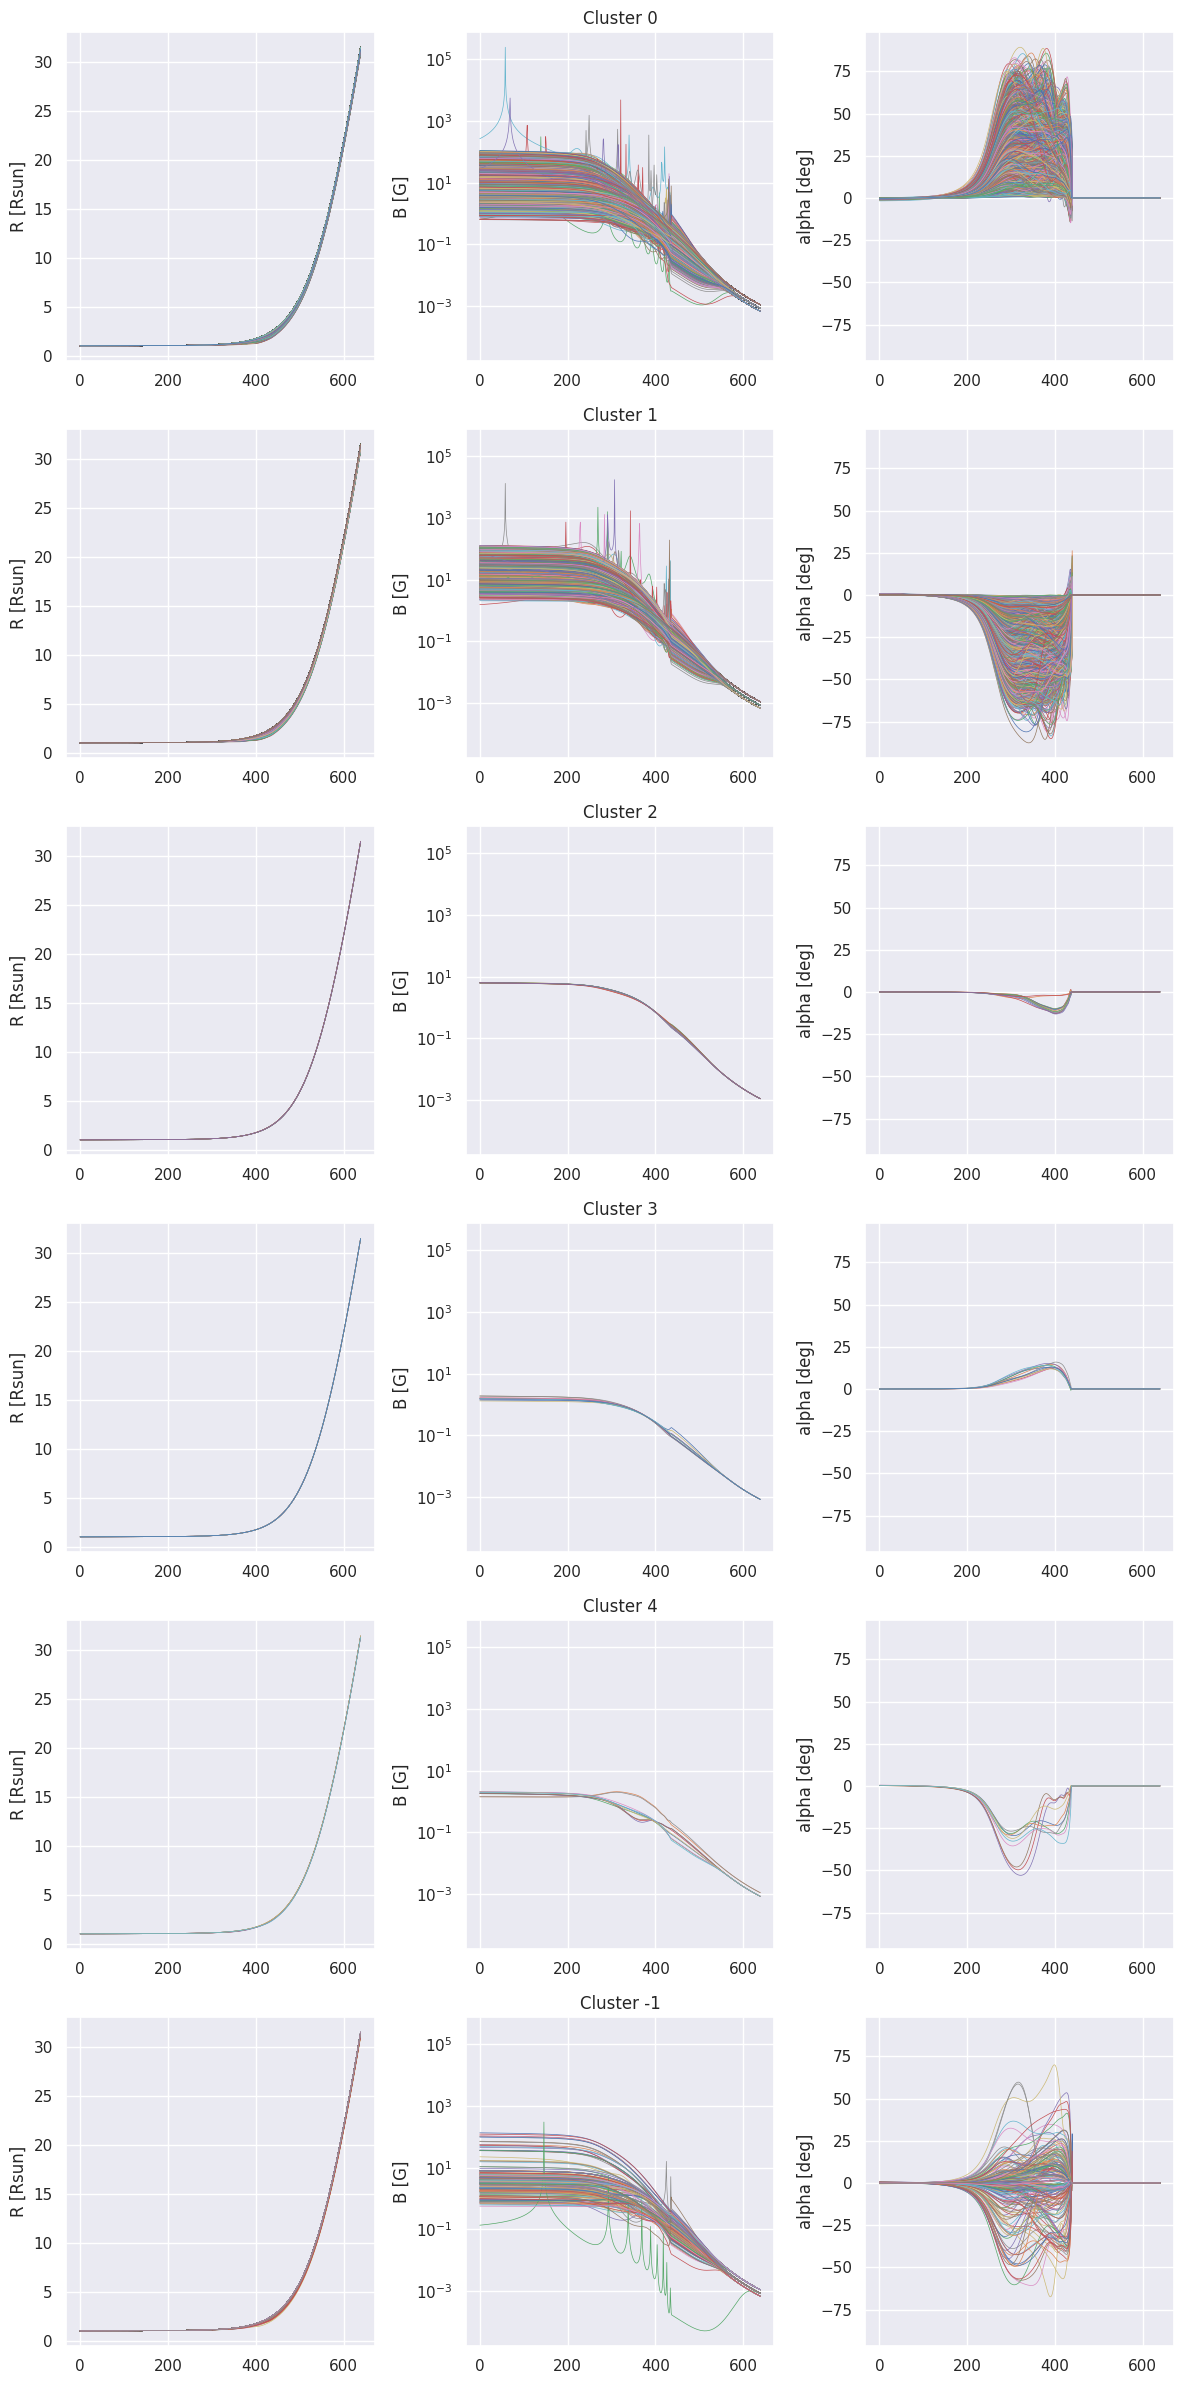

In [ ]:
plot_unscaled_clusters(dbscan_mag_inc_labels, nclusters, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

<AxesSubplot: ylabel='count'>

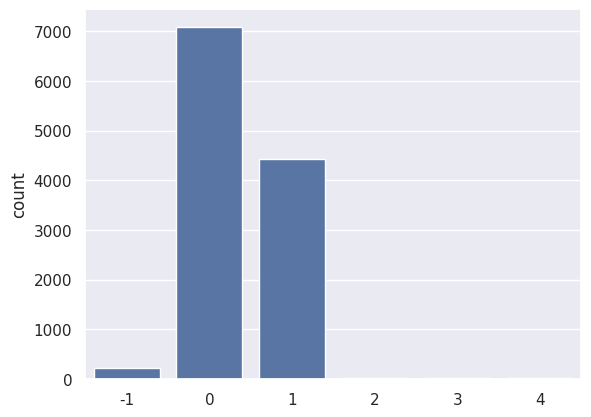

In [ ]:
sns.countplot(x=dbscan_mag_inc_labels, color='b')

In [ ]:
# %%capture
# sub_dir = OUT_DIR / 'alpha_dbscan'
# if not sub_dir.exists():
#     sub_dir.mkdir()
# for i in np.arange(0.2, 0.5, 0.05):
#     dbscan = DBSCAN(eps=i, min_samples=10, n_jobs=2)
#     dbscan_alpha_labels = dbscan.fit_predict(transformed_alpha)
    
#     save_i = int(round(i, 2) *100)
#     sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=dbscan_alpha_labels, palette='Set1')
#     plt.legend(loc='upper right')
#     plt.savefig(sub_dir / f'dbscan_scatter_{save_i}.png', dpi=200)
    
#     plot_unscaled_clusters(dbscan_alpha_labels, len(set(dbscan_alpha_labels)), flows_dict, flow_columns, save_path=sub_dir / f'dbscan_{save_i}.png')
    